In [375]:
import pandas as pd
import pathlib
import pandas_profiling
import numpy as np

In [5]:
PARSER_PATH = pathlib.Path('../parser/cars_parsing')
JSLINES_PATH = PARSER_PATH/"cars.jl"

In [316]:
data = pd.read_json(JSLINES_PATH,lines=True)

In [25]:
data_profile = pandas_profiling.ProfileReport(data)

In [81]:
data_profile

In [145]:
data_profile.to_file('car_report.html')

In [146]:
data.price_cur.value_counts()

USD    27492
EUR     1042
UAH      435
Name: price_cur, dtype: int64

In [317]:
data = data[data.price_cur=='USD']

In [318]:
data = data.drop_duplicates(subset=['id'])

In [168]:
data.fuel_type.value_counts()

Дизель              11163
Бензин               9636
Газ/бензин           3756
Электро               492
Гибрид                290
Газ                    73
Газ метан              29
Газ пропан-бутан       13
Другое                  6
Name: fuel_type, dtype: int64

In [319]:
COLUMNS_TO_DROP = ["body_id", "brand_id","brand_name_html",\
                   "color_html", "fuel_html", "is_abroad","is_confiscated","is_customed",\
                   "mileage_unitcode","model_id","price_html", "year", "price_cur","name", "model_name"]

In [320]:
data = data.drop(COLUMNS_TO_DROP,axis=1)

In [321]:
NUM_COLUMNS_TO_PARSE = ["engine_volume",
                        "with_exchange",
                        "with_auction",
                        "id",
                        "is_damaged",
                        "is_repaired"]

In [322]:
for column in NUM_COLUMNS_TO_PARSE:
    data[column] = pd.to_numeric(data[column].str.replace('"',""))

In [323]:
data = data.set_index(['id'])

In [175]:
new_report = pandas_profiling.ProfileReport(data)

In [176]:
new_report

In [324]:
data.columns

Index(['absolute_url', 'body_type', 'brand_name', 'color', 'description',
       'engine_volume', 'fuel_type', 'image_urls', 'is_damaged', 'is_repaired',
       'mileage_value', 'model', 'modification', 'price', 'prod_date', 'race',
       'tag_names', 'tags', 'transmission', 'with_auction', 'with_exchange'],
      dtype='object')

In [325]:
CATEGOROCAL_COLS = ['body_type','brand_name','color','fuel_type','model','with_auction','with_exchange','is_damaged','is_repaired','transmission']
NUM_COLS = ['engine_volume','mileage_value','price','prod_date']

In [377]:
features_for_training = data[CATEGOROCAL_COLS+NUM_COLS]

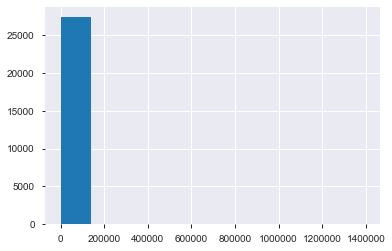

In [378]:
features_for_training.price.hist()

# Removing noise from target domain

In [379]:
def get_inliers_ind(data, feature_name, is_positive=True):

    """
    Generate inliers indecies using IQR

    :param data: pd.Dataframe
    :param feature_name: feature
    :param is_positive:
    :return:
    """

    q1 = data[feature_name].quantile(q=0.25)
    q3 = data[feature_name].quantile(q=0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    if is_positive:
        lower_bound = max(0, lower_bound)
    mask = (data[feature_name] > upper_bound) | (data[feature_name] < lower_bound)
    indecies = mask[mask == False].index
    return set(indecies)

In [380]:
inliers_price = get_inliers_ind(features_for_training,'price')
inliers_mileage = get_inliers_ind(features_for_training,'mileage_value')

inliers = inliers_price & inliers_mileage 

In [381]:
cleaned_features = features_for_training.loc[list(inliers)]

In [383]:
cleaned_features.to_csv('cleaned_data.csv',
                        index_label="index")

In [385]:
pd.read_csv('../HA8/data/cleaned_data.csv', 
            index_col='index')

,body_type,brand_name,color,fuel_type,model,with_auction,with_exchange,is_damaged,is_repaired,transmission,engine_volume,mileage_value,price,prod_date
index,,,,,,,,,,,,,,
24510473,Хэтчбек,Skoda,Красный,Газ/бензин,Fabia,1,0,0,0,Ручная / Механика,1.20,200000,6400.0,2012
24772621,Внедорожник / Кроссовер,Nissan,Черный,Дизель,X-Trail,1,0,0,0,Автомат,2.00,140000,27500.0,2017
25165843,Универсал,Volkswagen,Белый,Дизель,Passat B7,0,0,0,0,Автомат,2.00,215000,14700.0,2013
24379420,Внедорожник / Кроссовер,Land Rover,NaN,Бензин,Range Rover,0,1,0,0,Автомат,5.00,97000,28500.0,2012
24903710,Самосвал,ЗИЛ,Синий,Газ/бензин,ММЗ 554,1,0,0,0,Ручная / Механика,6.00,27000,4100.0,1991
25165857,Хэтчбек,BMW,Синий,Бензин,4 Series Gran Coupe,1,0,0,0,Типтроник,2.00,63000,22000.0,2014
18350116,Седан,Mazda,Бежевый,Газ/бензин,6,1,0,0,0,Ручная / Механика,2.00,200000,5300.0,2004
24117284,Седан,Audi,Синий,Дизель,A6,1,1,0,0,Типтроник,2.50,302000,8000.0,2003
25034800,Универсал,Peugeot,Белый,Дизель,Bipper пасс.,0,0,0,0,Ручная / Механика,1.30,220000,6950.0,2010


In [361]:
for column in CATEGOROCAL_COLS:
    cleaned_features[column] =  cleaned_features[column].astype('category').cat.codes 

In [355]:
# cleaned_report = pandas_profiling.ProfileReport(cleaned_features)

# cleaned_report.to_file('cleaned_report.html')

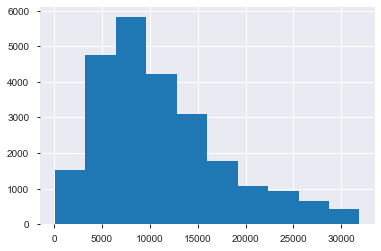

In [356]:
cleaned_features.price.hist()

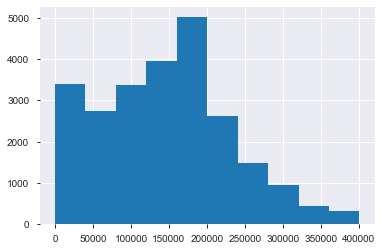

In [357]:
cleaned_features.mileage_value.hist()

In [358]:
cleaned_features['model_years_old'] = 2019 - cleaned_features['prod_date']

In [359]:
cleaned_features.drop(['prod_date'],axis=1,inplace=True)

# Baseline_model 

In [363]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(max_depth=20,
                        num_leaves=128,
                        learning_rate=.05,
                        n_estimators=600,
                        bagging_fraction=.6,
                        feature_fraction=.6,
                        random_state=42)

In [288]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=20,
                           max_features =.7)

In [364]:
features = cleaned_features.drop(['price'],axis=1)
price = cleaned_features[['price']]

In [365]:
from sklearn.metrics import make_scorer
mae_scorer = make_scorer(mean_absolute_error)

In [366]:
mae_scores = cross_val_score(lgb_reg, 
                features,
                price,
                cv=5,
                verbose=2,
                scoring = mae_scorer,
                n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


In [367]:
mae_scores.mean()

1545.112110222047

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131fc1410>]],
      dtype=object)

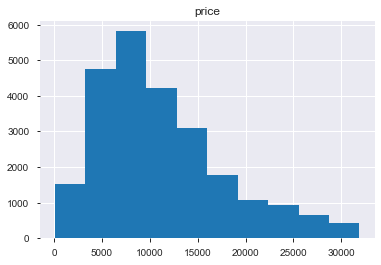

In [262]:
price.hist()

In [368]:
lgb_reg.fit(features, price)

LGBMRegressor(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.6,
              importance_type='split', learning_rate=0.05, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_leaves=128, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [371]:
features_stat = np.array(list(zip(lgb_reg.feature_importances_, features.columns)))

In [372]:
features_val = features_stat[...,0].astype(np.uint32)
features_val = features_val/np.sum(features_val)
features_ind = np.argsort(features_val)[::-1]

In [373]:
features_to_plot = np.array(list(zip(features_val, features.columns)))

In [374]:
features_to_plot[features_ind]

array([['0.19556014182145315', 'model'],
       ['0.17739588294438272', 'mileage_value'],
       ['0.1277186855056358', 'brand_name'],
       ['0.11059956606868815', 'engine_volume'],
       ['0.1083769910567815', 'body_type'],
       ['0.10798010266179817', 'model_years_old'],
       ['0.06269513679420013', 'color'],
       ['0.03705614647827697', 'fuel_type'],
       ['0.028655342117796474', 'transmission'],
       ['0.024884902365454833', 'with_auction'],
       ['0.01640472032597767', 'with_exchange'],
       ['0.0026723818595544265', 'is_damaged'],
       ['0.0', 'is_repaired']], dtype='<U32')